In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import pickle
import joblib

In [7]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Set style untuk plotting
plt.style.use('default')
sns.set_palette("husl")

# Create directory untuk menyimpan gambar
if not os.path.exists('gambar'):
    os.makedirs('gambar')

print("="*80)
print("CAPSTONE PROJECT - OBESITY CLASSIFICATION")
print("Universitas Dian Nuswantoro - Bengkel Koding Data Science")
print("="*80)


CAPSTONE PROJECT - OBESITY CLASSIFICATION
Universitas Dian Nuswantoro - Bengkel Koding Data Science



# TAHAP 1: EXPLORATORY DATA ANALYSIS (EDA) #



1.1 Loading Dataset...
✓ Dataset berhasil dimuat dari path lokal!
✓ Path: C:\Semester6\bengkel koding\UAS Bengkod\ObesityDataSet.csv

1.2 Inspeksi Data Awal
------------------------------
Shape dataset: (2111, 17)
Jumlah baris: 2111
Jumlah kolom: 17

Beberapa baris pertama:
  Age  Gender Height Weight        CALC FAVC FCVC NCP  SCC SMOKE CH2O  \
0  21  Female   1.62     64          no   no    2   3   no    no    2   
1  21  Female   1.52     56   Sometimes   no    3   3  yes   yes    3   
2  23    Male    1.8     77  Frequently   no    2   3   no    no    2   
3  27    Male    1.8     87  Frequently   no    3   3   no    no    2   
4  22    Male   1.78   89.8   Sometimes   no    2   1   no    no    2   

  family_history_with_overweight FAF TUE       CAEC                 MTRANS  \
0                            yes   0   1  Sometimes  Public_Transportation   
1                            yes   3   0  Sometimes  Public_Transportation   
2                            yes   2   1  Sometimes

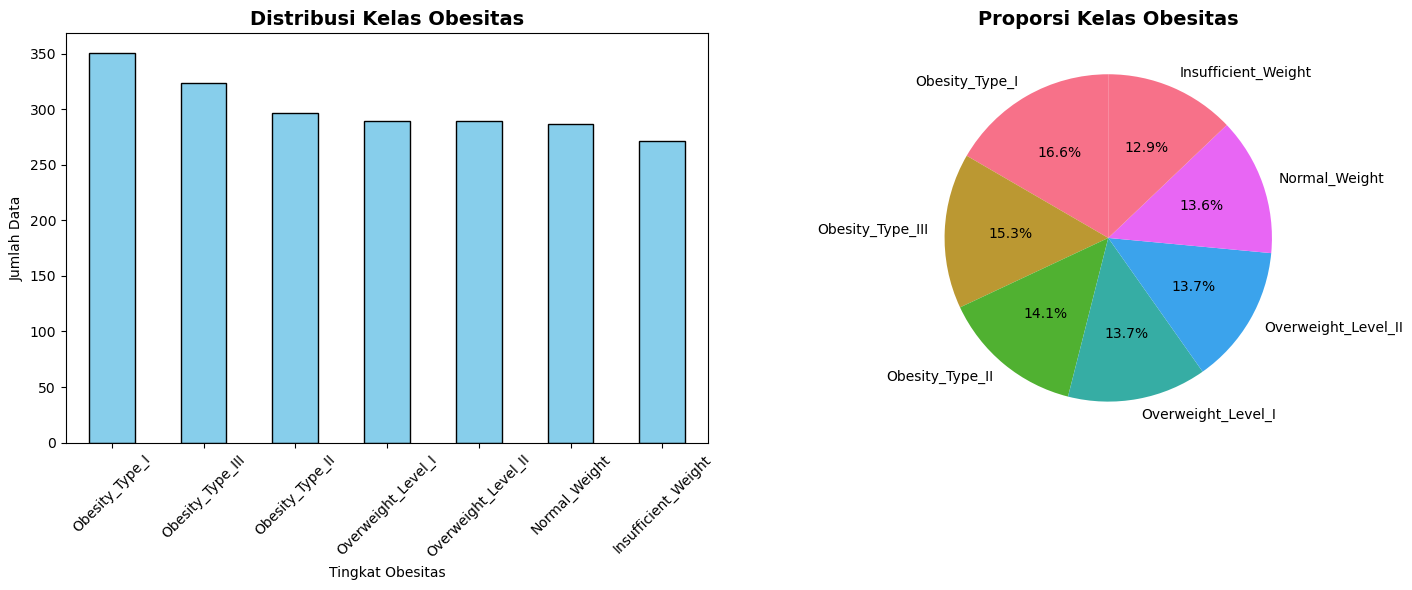

In [8]:
# 1.1 Load Dataset
print("\n1.1 Loading Dataset...")
dataset_path = r"C:\Semester6\bengkel koding\UAS Bengkod\ObesityDataSet.csv"

try:
    df = pd.read_csv(dataset_path)
    print("✓ Dataset berhasil dimuat dari path lokal!")
    print(f"✓ Path: {dataset_path}")
except FileNotFoundError:
    print("✗ File tidak ditemukan!")
    print(f"✗ Path yang dicari: {dataset_path}")
    print("Pastikan file CSV ada di lokasi tersebut dan nama file sesuai")
    exit()
except Exception as e:
    print(f"✗ Error loading dataset: {e}")
    exit()

# 1.2 Inspeksi Data Awal
print("\n1.2 Inspeksi Data Awal")
print("-" * 30)
print(f"Shape dataset: {df.shape}")
print(f"Jumlah baris: {df.shape[0]}")
print(f"Jumlah kolom: {df.shape[1]}")

print("\nBeberapa baris pertama:")
print(df.head())

print("\nInformasi umum dataset:")
print(df.info())

print("\nDeskripsi statistik:")
print(df.describe())

# 1.3 Analisis Missing Values dan Data Quality
print("\n1.3 Analisis Data Quality")
print("-" * 30)
print("Missing values per kolom:")
missing_values = df.isnull().sum()
print(missing_values)

print(f"\nTotal missing values: {missing_values.sum()}")
print(f"Data duplikat: {df.duplicated().sum()}")

print("\nUnique values per kolom:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

# 1.4 Analisis Target Variable
print("\n1.4 Analisis Target Variable (NObeyesdad)")
print("-" * 40)
target_counts = df['NObeyesdad'].value_counts()
print("Distribusi kelas target:")
print(target_counts)

target_pct = df['NObeyesdad'].value_counts(normalize=True) * 100
print("\nPersentase distribusi:")
for i, (cls, pct) in enumerate(target_pct.items()):
    print(f"{cls}: {pct:.2f}%")

# Visualisasi distribusi target
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot
target_counts.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Distribusi Kelas Obesitas', fontsize=14, fontweight='bold')
ax1.set_xlabel('Tingkat Obesitas')
ax1.set_ylabel('Jumlah Data')
ax1.tick_params(axis='x', rotation=45)

# Pie chart
ax2.pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%', startangle=90)
ax2.set_title('Proporsi Kelas Obesitas', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('gambar/01_distribusi_target.png', dpi=300, bbox_inches='tight')
plt.show()


1.5 Analisis Fitur Kategorikal
-----------------------------------


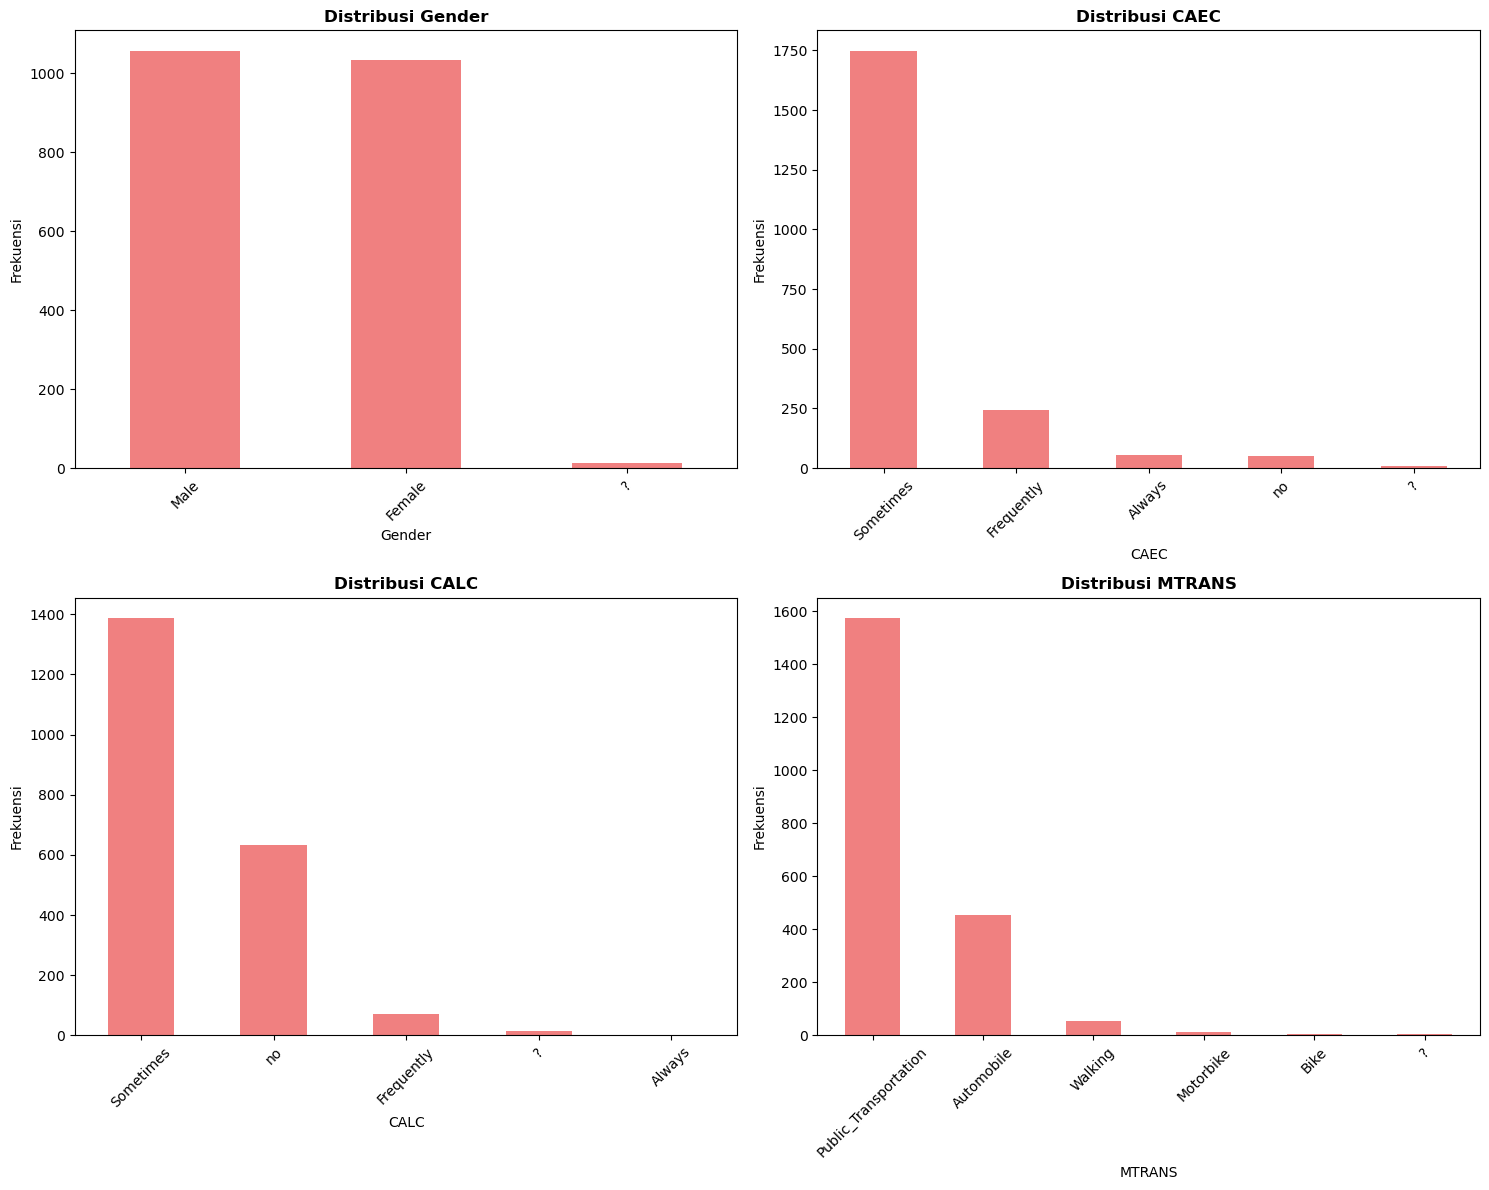


Hubungan fitur kategorikal dengan target:

Gender:
NObeyesdad  Insufficient_Weight  Normal_Weight  Obesity_Type_I  \
Gender                                                           
?                         23.08          23.08            0.00   
Female                    16.46          13.46           15.10   
Male                       9.28          13.73           18.47   

NObeyesdad  Obesity_Type_II  Obesity_Type_III  Overweight_Level_I  \
Gender                                                              
?                      7.69             23.08               23.08   
Female                 0.19             30.88               13.94   
Male                  27.56              0.09               13.26   

NObeyesdad  Overweight_Level_II  
Gender                           
?                          0.00  
Female                     9.97  
Male                      17.61  

CAEC:
NObeyesdad  Insufficient_Weight  Normal_Weight  Obesity_Type_I  \
CAEC                        

In [9]:
# 1.5 Analisis Fitur Kategorikal
print("\n1.5 Analisis Fitur Kategorikal")
print("-" * 35)

categorical_features = ['Gender', 'CAEC', 'CALC', 'MTRANS']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, feature in enumerate(categorical_features):
    if feature in df.columns:
        df[feature].value_counts().plot(kind='bar', ax=axes[i], color='lightcoral')
        axes[i].set_title(f'Distribusi {feature}', fontweight='bold')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frekuensi')
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('gambar/02_distribusi_kategorikal.png', dpi=300, bbox_inches='tight')
plt.show()

# Cross-tabulation dengan target
print("\nHubungan fitur kategorikal dengan target:")
for feature in categorical_features:
    if feature in df.columns:
        print(f"\n{feature}:")
        crosstab = pd.crosstab(df[feature], df['NObeyesdad'], normalize='index') * 100
        print(crosstab.round(2))


1.6 Analisis Fitur Numerik
------------------------------
Kolom yang tersedia dalam dataset:
['Age', 'Gender', 'Height', 'Weight', 'CALC', 'FAVC', 'FCVC', 'NCP', 'SCC', 'SMOKE', 'CH2O', 'family_history_with_overweight', 'FAF', 'TUE', 'CAEC', 'MTRANS', 'NObeyesdad']

Kolom numerik yang terdeteksi: []
Tidak ada kolom numerik terdeteksi, mencoba konversi...
✓ Age berhasil dikonversi ke numerik
✓ Height berhasil dikonversi ke numerik
✓ Weight berhasil dikonversi ke numerik
✓ NCP berhasil dikonversi ke numerik
✓ CH2O berhasil dikonversi ke numerik
✓ FAF berhasil dikonversi ke numerik
✓ TUE berhasil dikonversi ke numerik
✓ FCVC berhasil dikonversi ke numerik

Statistik deskriptif fitur numerik:
               Age       Height       Weight          NCP         CH2O  \
count  2089.000000  2089.000000  2092.000000  2089.000000  2096.000000   
mean     24.717928     1.706623    88.608184     2.729418     2.030560   
std       8.391323     0.117700    36.154617     0.981124     0.737945   
min  

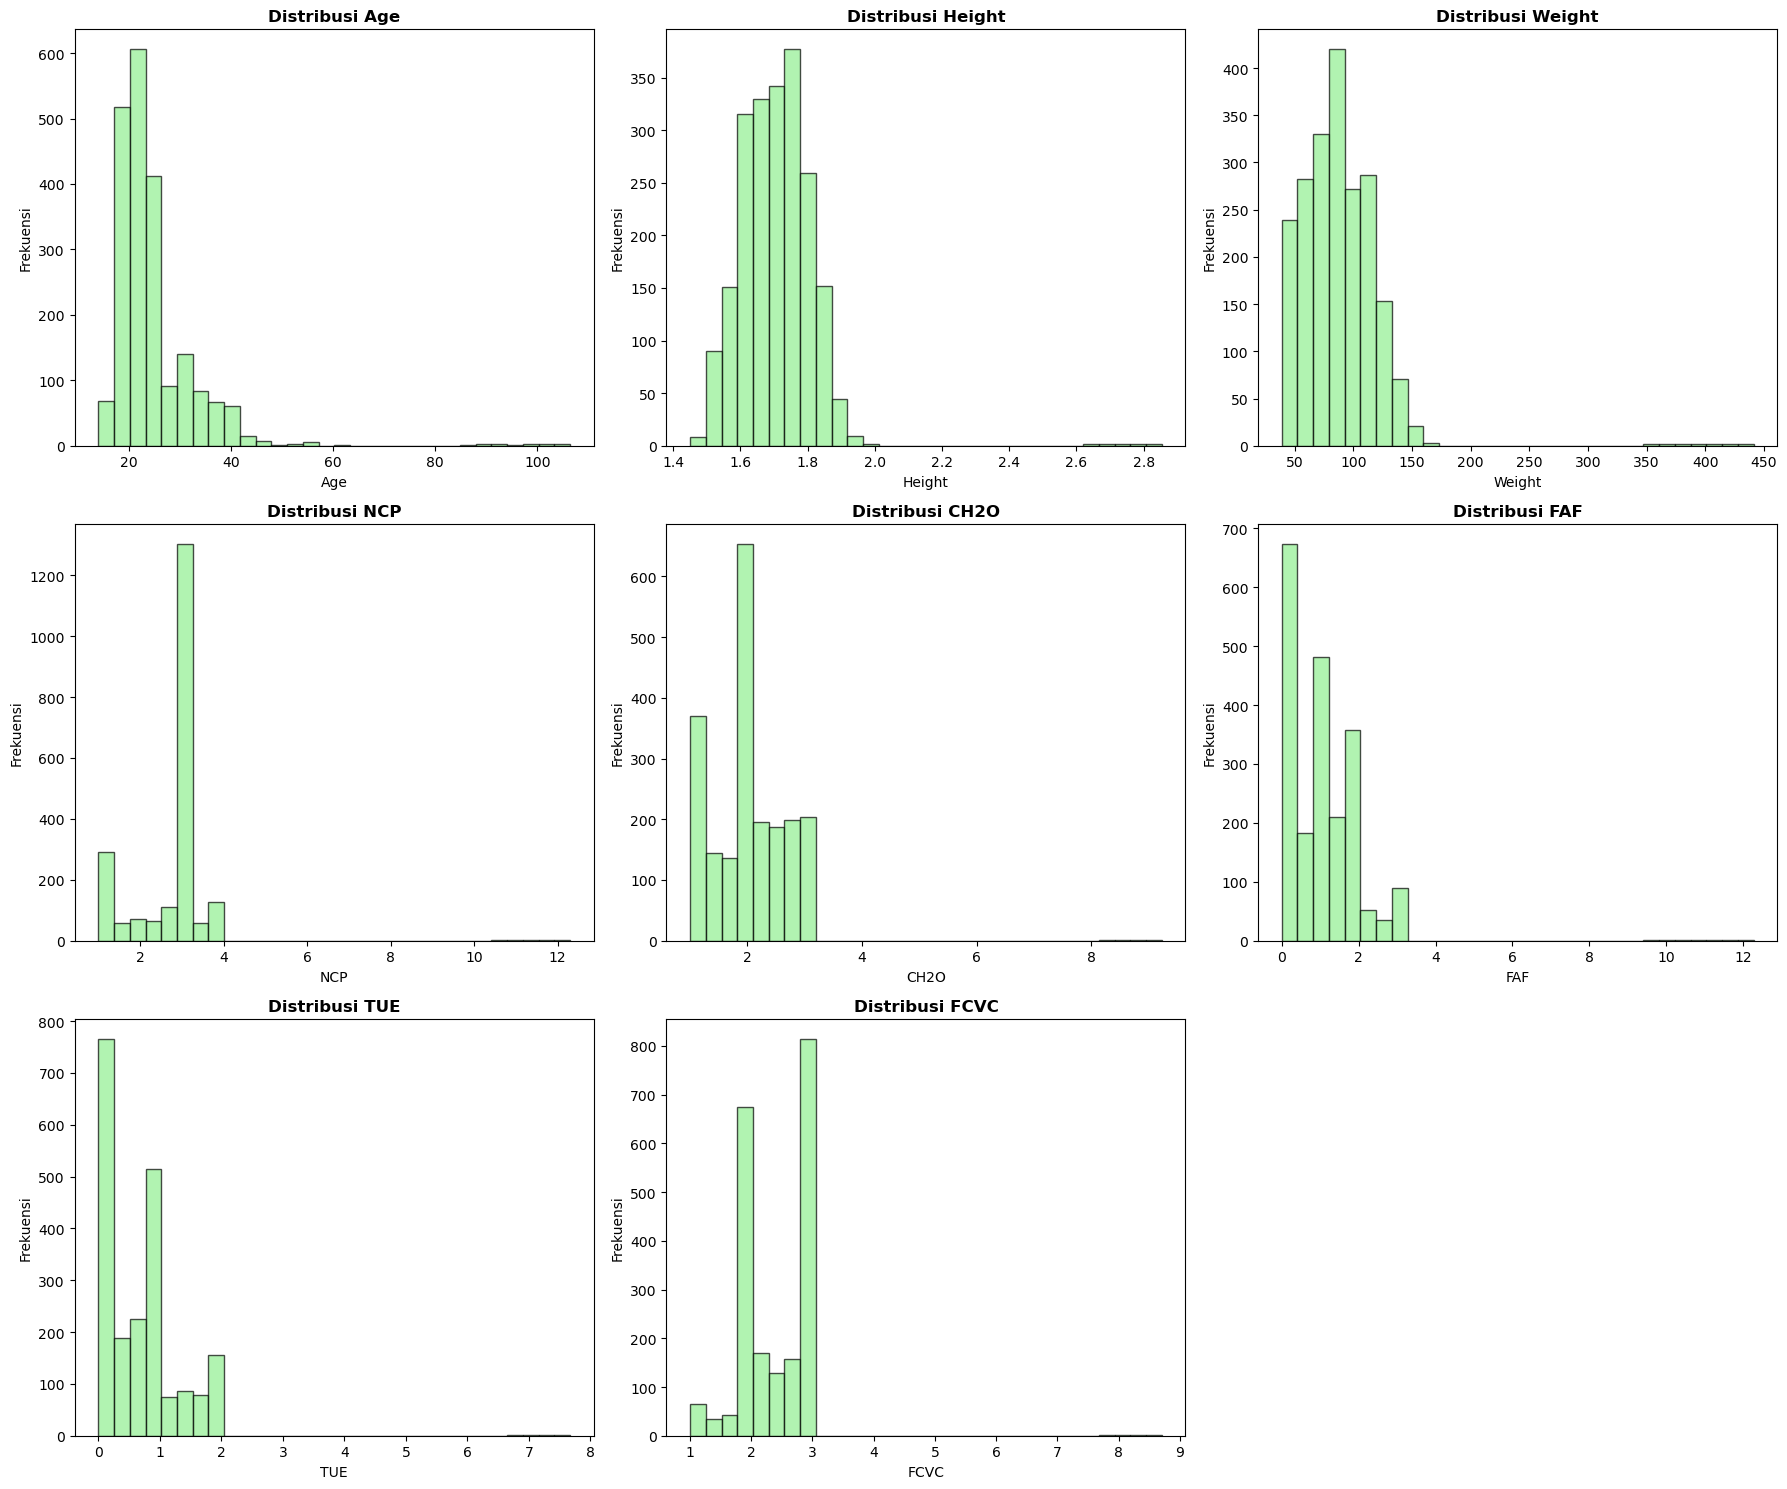

In [11]:
# 1.6 Analisis Fitur Numerik
print("\n1.6 Analisis Fitur Numerik")
print("-" * 30)

# Tampilkan semua kolom yang ada dalam dataset
print("Kolom yang tersedia dalam dataset:")
print(df.columns.tolist())

# Identifikasi kolom numerik otomatis
numeric_df = df.select_dtypes(include=[np.number])
print(f"\nKolom numerik yang terdeteksi: {numeric_df.columns.tolist()}")

# Jika tidak ada kolom numerik, coba konversi beberapa kolom
if numeric_df.empty:
    print("Tidak ada kolom numerik terdeteksi, mencoba konversi...")
    potential_numeric = ['Age', 'Height', 'Weight', 'NCP', 'CH2O', 'FAF', 'TUE', 'FCVC']
    numeric_cols = []
    
    for col in potential_numeric:
        if col in df.columns:
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                numeric_cols.append(col)
                print(f"✓ {col} berhasil dikonversi ke numerik")
            except:
                print(f"✗ {col} gagal dikonversi")
    
    numeric_df = df[numeric_cols] if numeric_cols else df.select_dtypes(include=[np.number])

# Statistik deskriptif untuk fitur numerik
if not numeric_df.empty:
    print("\nStatistik deskriptif fitur numerik:")
    print(numeric_df.describe())
else:
    print("Tidak ada fitur numerik yang dapat dianalisis")
    numeric_df = pd.DataFrame()  # Create empty DataFrame to avoid errors later

# Histogram untuk fitur numerik
if not numeric_df.empty:
    num_cols = len(numeric_df.columns)
    if num_cols > 0:
        # Calculate subplot layout
        n_rows = (num_cols + 2) // 3  # Round up division
        n_cols_plot = min(3, num_cols)
        
        fig, axes = plt.subplots(n_rows, n_cols_plot, figsize=(18, 5*n_rows))
        
        # Handle case when there's only one subplot
        if num_cols == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes if num_cols > 1 else [axes]
        else:
            axes = axes.ravel()

        for i, feature in enumerate(numeric_df.columns):
            ax = axes[i] if num_cols > 1 else axes[0]
            ax.hist(numeric_df[feature].dropna(), bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
            ax.set_title(f'Distribusi {feature}', fontweight='bold')
            ax.set_xlabel(feature)
            ax.set_ylabel('Frekuensi')

        # Remove empty subplots if any
        if num_cols > 1:
            for j in range(num_cols, len(axes)):
                fig.delaxes(axes[j])

        plt.tight_layout()
        plt.savefig('gambar/03_histogram_numerik.png', dpi=300, bbox_inches='tight')
        plt.show()
else:
    print("Tidak ada fitur numerik untuk dibuat histogram")

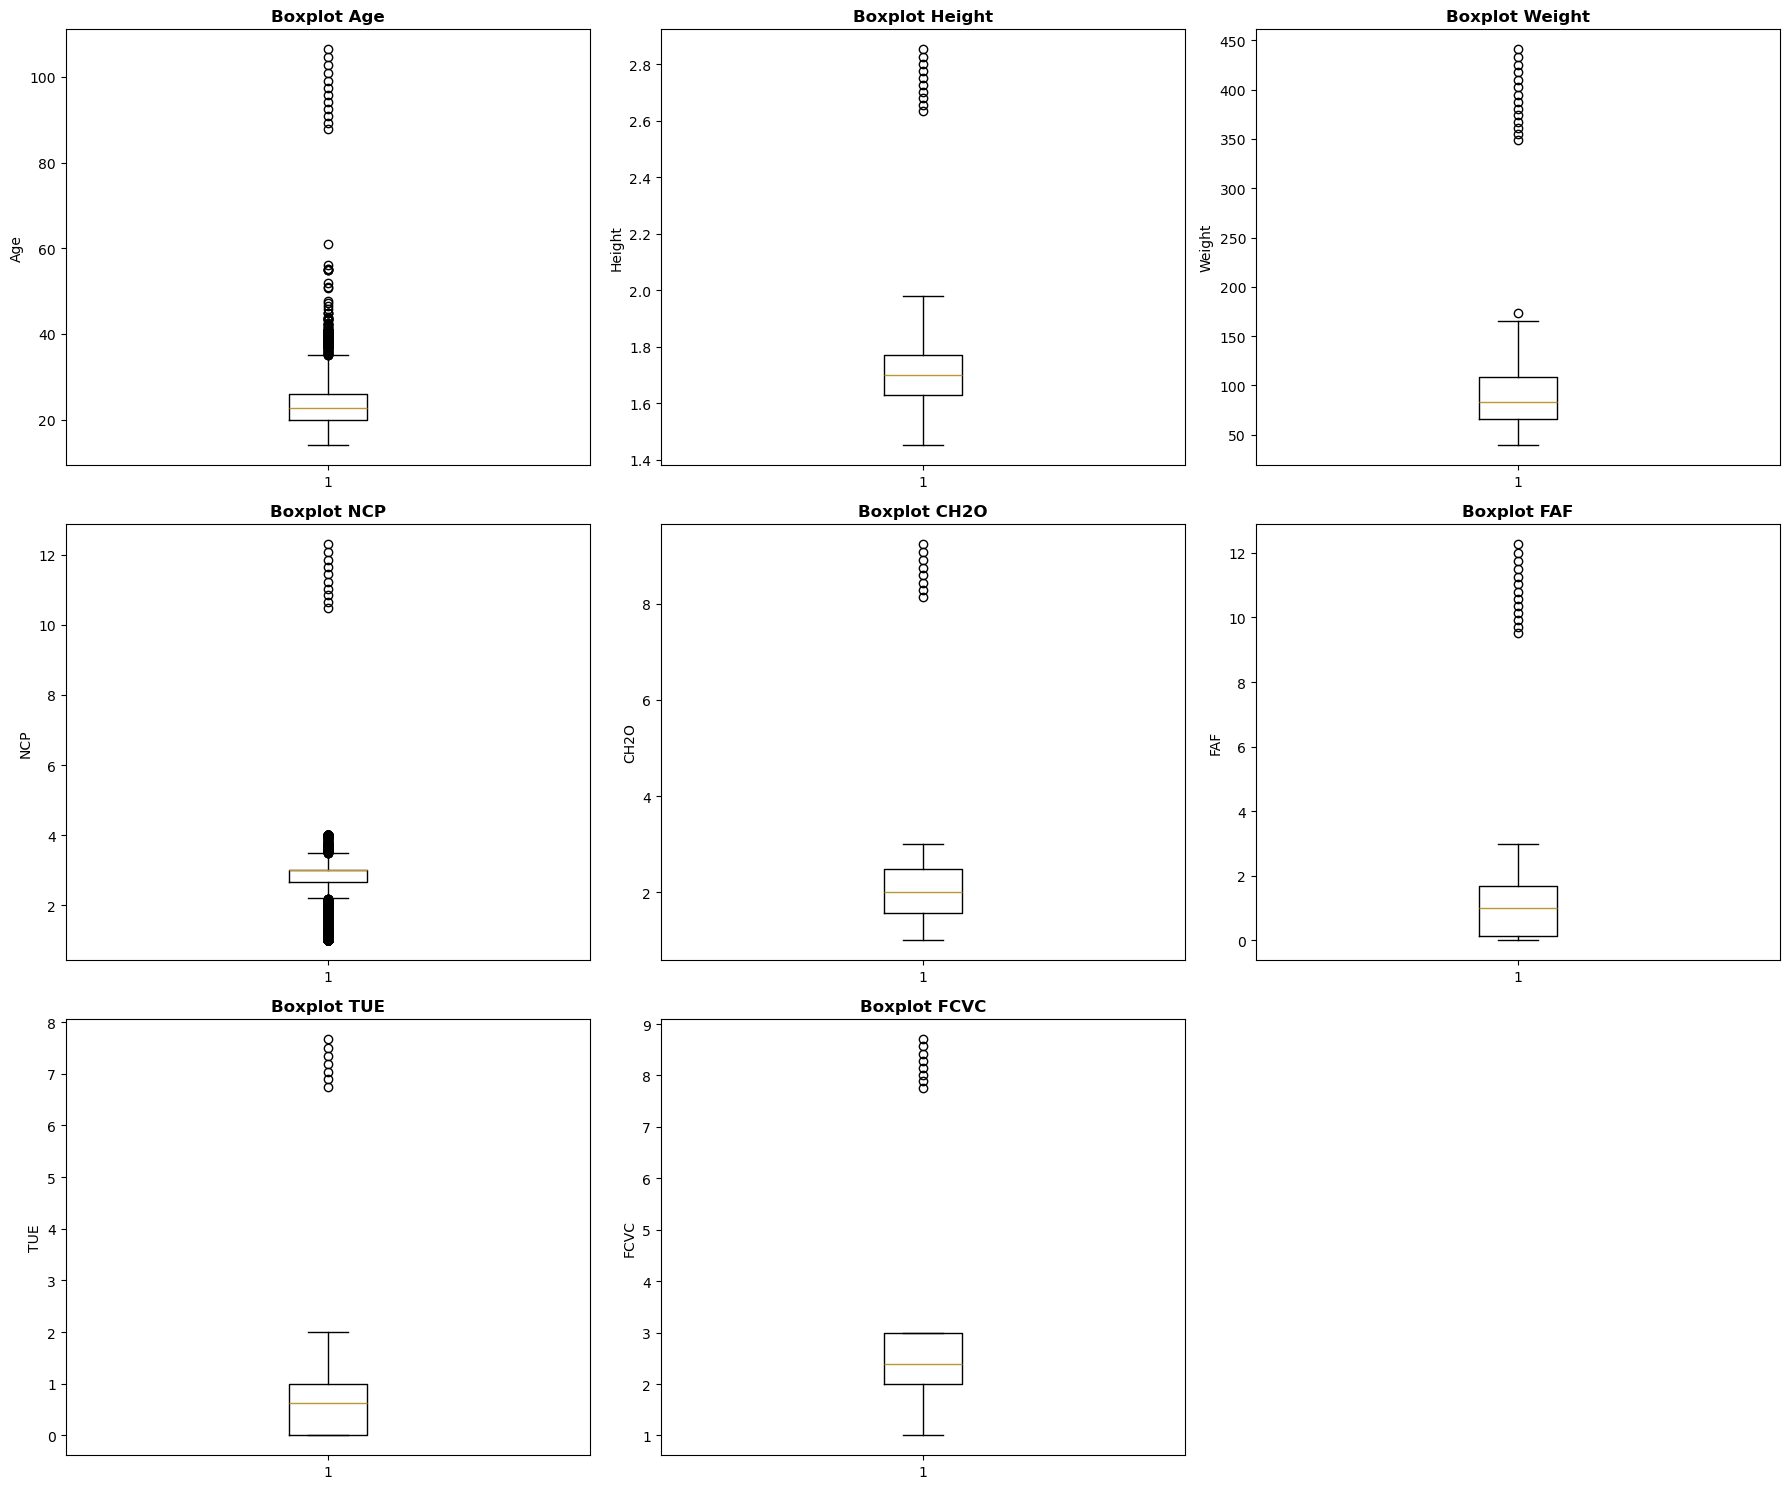

In [13]:
# Boxplot untuk deteksi outlier
if not numeric_df.empty:
    num_cols = len(numeric_df.columns)
    if num_cols > 0:
        # Calculate subplot layout
        n_rows = (num_cols + 2) // 3  # Round up division
        n_cols_plot = min(3, num_cols)
        
        fig, axes = plt.subplots(n_rows, n_cols_plot, figsize=(18, 5*n_rows))
        
        # Handle case when there's only one subplot
        if num_cols == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes if num_cols > 1 else [axes]
        else:
            axes = axes.ravel()

        for i, feature in enumerate(numeric_df.columns):
            ax = axes[i] if num_cols > 1 else axes[0]
            ax.boxplot(numeric_df[feature].dropna())
            ax.set_title(f'Boxplot {feature}', fontweight='bold')
            ax.set_ylabel(feature)

        # Remove empty subplots if any
        if num_cols > 1:
            for j in range(num_cols, len(axes)):
                fig.delaxes(axes[j])

        plt.tight_layout()
        plt.savefig('gambar/04_boxplot_outliers.png', dpi=300, bbox_inches='tight')
        plt.show()
else:
    print("Tidak ada fitur numerik untuk dibuat boxplot")


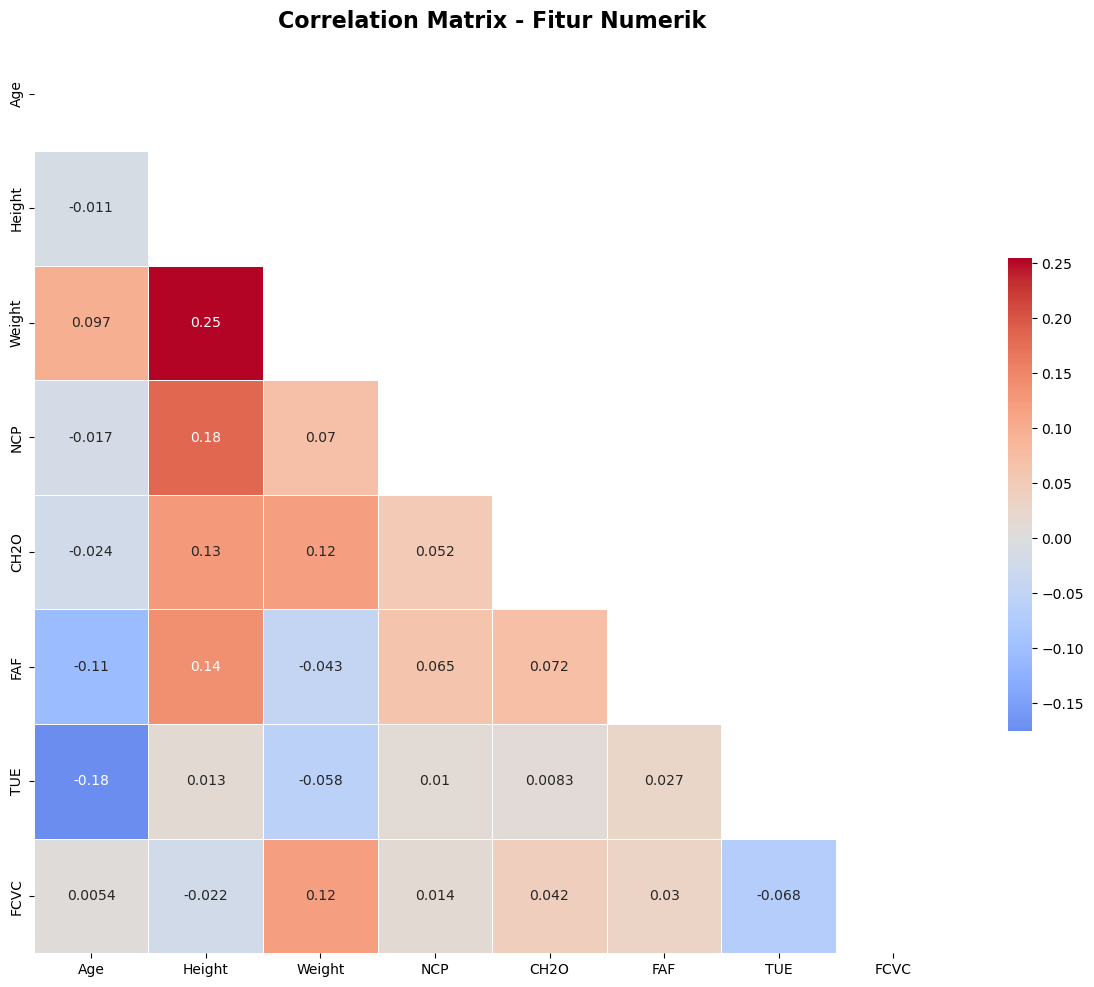

In [15]:
# correlation matrix
if not numeric_df.empty and len(numeric_df.columns) > 1:
    plt.figure(figsize=(12, 10))
    correlation_matrix = numeric_df.corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": .5})
    plt.title('Correlation Matrix - Fitur Numerik', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('gambar/05_correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Tidak dapat membuat correlation matrix (tidak cukup fitur numerik)")


1.7 Analisis Fitur Biner
-------------------------


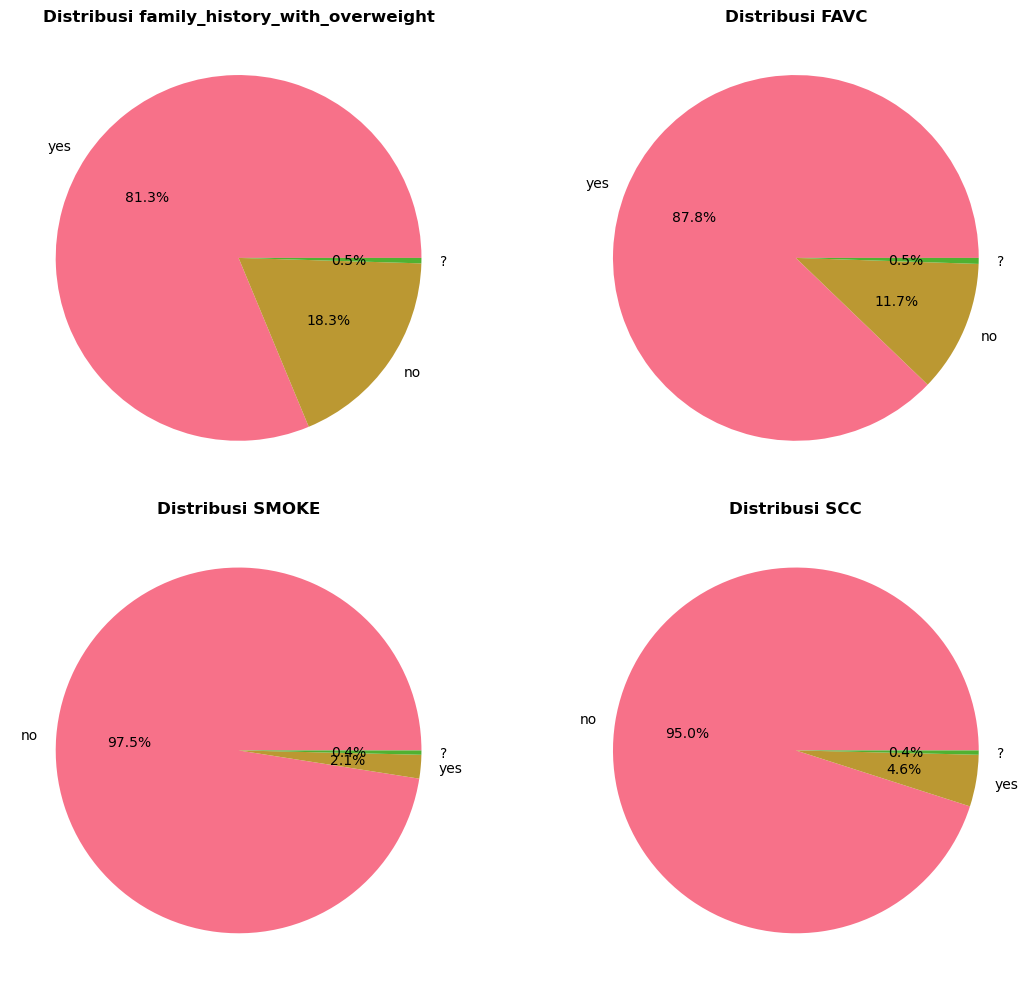

In [16]:
# 1.7 Analisis Fitur Biner
print("\n1.7 Analisis Fitur Biner")
print("-" * 25)

binary_features = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, feature in enumerate(binary_features):
    if feature in df.columns:
        df[feature].value_counts().plot(kind='pie', ax=axes[i], autopct='%1.1f%%')
        axes[i].set_title(f'Distribusi {feature}', fontweight='bold')
        axes[i].set_ylabel('')

plt.tight_layout()
plt.savefig('gambar/06_distribusi_biner.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
# 1.8 Kesimpulan EDA
print("\n1.8 Kesimpulan EDA")
print("-" * 20)
print("✓ Dataset memiliki", df.shape[0], "baris dan", df.shape[1], "kolom")
print("✓ Tidak ada missing values" if missing_values.sum() == 0 else f"✗ Terdapat {missing_values.sum()} missing values")
print("✓ Tidak ada data duplikat" if df.duplicated().sum() == 0 else f"✗ Terdapat {df.duplicated().sum()} data duplikat")
print("✓ Target variable memiliki", df['NObeyesdad'].nunique(), "kelas")
print("✓ Terdapat", len(categorical_features), "fitur kategorikal,", len(numeric_features), "fitur numerik, dan", len(binary_features), "fitur biner")



1.8 Kesimpulan EDA
--------------------
✓ Dataset memiliki 2111 baris dan 17 kolom
✗ Terdapat 150 missing values
✗ Terdapat 18 data duplikat
✓ Target variable memiliki 7 kelas
✓ Terdapat 4 fitur kategorikal, 8 fitur numerik, dan 4 fitur biner


# TAHAP 2: PREPROCESSING DATA

In [21]:
# 2.1 Handle Missing Values (jika ada)
print("\n2.1 Handling Missing Values")
print("-" * 30)
if df.isnull().sum().sum() == 0:
    print("✓ Tidak ada missing values yang perlu ditangani")
else:
    print("Missing values detected, handling...")
    # Implement missing value handling here

# 2.2 Handle Outliers
print("\n2.2 Handling Outliers")
print("-" * 25)

def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

outlier_summary = {}
if not numeric_df.empty:
    for feature in numeric_df.columns:
        outliers, lower, upper = detect_outliers_iqr(df, feature)
        outlier_summary[feature] = len(outliers)
        print(f"{feature}: {len(outliers)} outliers detected")
else:
    print("Tidak ada fitur numerik untuk deteksi outlier")

# 2.3 Feature Engineering
print("\n2.3 Feature Engineering")
print("-" * 25)

# Create BMI feature jika Height dan Weight tersedia
if 'Height' in df.columns and 'Weight' in df.columns:
    df['BMI'] = df['Weight'] / (df['Height'] ** 2)
    print("✓ BMI feature created")
else:
    print("✗ Tidak dapat membuat BMI (Height/Weight tidak tersedia)")

# 2.4 Encoding Categorical Variables
print("\n2.4 Encoding Categorical Variables")
print("-" * 35)

# Make a copy for preprocessing
df_processed = df.copy()

# Label encoding untuk target variable
le_target = LabelEncoder()
df_processed['NObeyesdad_encoded'] = le_target.fit_transform(df_processed['NObeyesdad'])

# Mapping target classes
target_mapping = dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))
print("Target encoding mapping:")
for original, encoded in target_mapping.items():
    print(f"  {original} -> {encoded}")

# Identifikasi fitur kategorikal dan biner yang benar-benar ada
actual_categorical = []
actual_binary = []

potential_categorical = ['Gender', 'CAEC', 'CALC', 'MTRANS']
potential_binary = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']

for col in potential_categorical:
    if col in df_processed.columns:
        actual_categorical.append(col)

for col in potential_binary:
    if col in df_processed.columns:
        actual_binary.append(col)

print(f"Categorical features found: {actual_categorical}")
print(f"Binary features found: {actual_binary}")

# Encoding untuk fitur kategorikal
label_encoders = {}

# Binary features (konversi ke 0/1)
for feature in actual_binary:
    unique_vals = df_processed[feature].unique()
    print(f"{feature} unique values: {unique_vals}")
    
    # Coba berbagai format nilai binary
    if set(unique_vals).issubset({'no', 'yes'}):
        df_processed[feature] = df_processed[feature].map({'no': 0, 'yes': 1})
    elif set(unique_vals).issubset({'No', 'Yes'}):
        df_processed[feature] = df_processed[feature].map({'No': 0, 'Yes': 1})
    elif set(unique_vals).issubset({0, 1}):
        pass  # Already binary
    else:
        # Use label encoding for other cases
        le = LabelEncoder()
        df_processed[feature] = le.fit_transform(df_processed[feature])
        label_encoders[feature] = le

# Categorical features dengan Label Encoding
for feature in actual_categorical:
    le = LabelEncoder()
    df_processed[feature + '_encoded'] = le.fit_transform(df_processed[feature])
    label_encoders[feature] = le
    print(f"✓ {feature} encoded")

print("✓ Semua categorical variables berhasil di-encode")

# 2.5 Feature Selection
print("\n2.5 Feature Selection")
print("-" * 22)

# Pilih fitur untuk modeling
feature_columns = []

# Numeric features (gunakan yang benar-benar ada)
if not numeric_df.empty:
    feature_columns.extend(numeric_df.columns.tolist())

# BMI jika tersedia
if 'BMI' in df_processed.columns:
    feature_columns.append('BMI')

# Binary features
feature_columns.extend(actual_binary)

# Encoded categorical features
for feature in actual_categorical:
    feature_columns.append(feature + '_encoded')

# Remove duplicates dan pastikan semua kolom ada
feature_columns = list(set(feature_columns))
feature_columns = [col for col in feature_columns if col in df_processed.columns]

print(f"✓ Selected {len(feature_columns)} features for modeling")
print("Features:", feature_columns)

# 2.6 Handle Missing Values dalam Features
print("\n2.6 Handle Missing Values dalam Features")
print("-" * 40)

# Pastikan feature_columns tersedia dan valid
if len(feature_columns) == 0:
    print("✗ Tidak ada fitur yang tersedia untuk modeling")
    exit()

# Filter feature_columns untuk memastikan semua kolom ada
available_features = [col for col in feature_columns if col in df_processed.columns]
if len(available_features) < len(feature_columns):
    print(f"Warning: {len(feature_columns) - len(available_features)} fitur tidak tersedia")
    feature_columns = available_features

X = df_processed[feature_columns].copy()
y = df_processed['NObeyesdad_encoded']

print(f"Selected features: {len(feature_columns)}")
print("Checking for missing values in features...")

# Cek missing values per kolom
missing_summary = X.isnull().sum()
total_missing = missing_summary.sum()

print(f"Total missing values: {total_missing}")

if total_missing > 0:
    print("\nMissing values per column:")
    for col, missing_count in missing_summary.items():
        if missing_count > 0:
            print(f"  {col}: {missing_count} missing values")
    
    print("\nHandling missing values...")
    
    # Impute missing values
    from sklearn.impute import SimpleImputer
    
    # Identifikasi kolom numerik dan non-numerik
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
    
    # Impute numeric columns with median
    if numeric_cols:
        numeric_imputer = SimpleImputer(strategy='median')
        X[numeric_cols] = numeric_imputer.fit_transform(X[numeric_cols])
        print(f"✓ Imputed {len(numeric_cols)} numeric columns with median")
    
    # Impute non-numeric columns with mode
    if non_numeric_cols:
        categorical_imputer = SimpleImputer(strategy='most_frequent')
        X[non_numeric_cols] = categorical_imputer.fit_transform(X[non_numeric_cols])
        print(f"✓ Imputed {len(non_numeric_cols)} categorical columns with mode")
    
    # Verify no missing values remain
    remaining_missing = X.isnull().sum().sum()
    print(f"✓ Remaining missing values: {remaining_missing}")
    
else:
    print("✓ No missing values found in features")

# Ensure all data is numeric for SMOTE
print("\nEnsuring all features are numeric...")
for col in X.columns:
    if X[col].dtype == 'object':
        print(f"Converting {col} to numeric...")
        try:
            X[col] = pd.to_numeric(X[col], errors='coerce')
            # Fill any new NaN values created by conversion
            if X[col].isnull().sum() > 0:
                X[col].fillna(X[col].median(), inplace=True)
        except:
            # If conversion fails, use label encoding
            le_temp = LabelEncoder()
            X[col] = le_temp.fit_transform(X[col].astype(str))

print("✓ All features are now numeric")
print(f"✓ Final feature matrix shape: {X.shape}")

# Final check for any remaining issues
final_missing = X.isnull().sum().sum()
has_inf = np.isinf(X.values).sum()

print(f"✓ Final missing values: {final_missing}")
print(f"✓ Infinite values: {has_inf}")

if final_missing > 0 or has_inf > 0:
    print("Cleaning remaining problematic values...")
    # Replace any remaining NaN with 0
    X.fillna(0, inplace=True)
    # Replace infinite values with large finite numbers
    X.replace([np.inf, -np.inf], [999999, -999999], inplace=True)

# 2.7 Handle Class Imbalance
print("\n2.7 Handle Class Imbalance")
print("-" * 30)

print("Class distribution before balancing:")
print(y.value_counts().sort_index())

# Apply SMOTE
try:
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    print("✓ SMOTE applied successfully")
    
    print("\nClass distribution after SMOTE:")
    print(pd.Series(y_balanced).value_counts().sort_index())
    
except Exception as e:
    print(f"✗ SMOTE failed: {e}")
    print("Using original data without balancing...")
    X_balanced, y_balanced = X, y

# 2.8 Train-Test Split
print("\n2.8 Train-Test Split")
print("-" * 22)

# Pastikan X_balanced dan y_balanced tersedia
if 'X_balanced' not in locals() or 'y_balanced' not in locals():
    print("✗ X_balanced atau y_balanced tidak tersedia, menggunakan data original...")
    X_balanced, y_balanced = X, y

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print(f"✓ Train set: {X_train.shape}")
print(f"✓ Test set: {X_test.shape}")

# 2.9 Feature Scaling (pindah setelah train-test split)
print("\n2.9 Feature Scaling")
print("-" * 20)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled using StandardScaler")
print(f"✓ Train set scaled: {X_train_scaled.shape}")
print(f"✓ Test set scaled: {X_test_scaled.shape}")

# Update X_train dan X_test dengan data yang sudah di-scale
X_train, X_test = X_train_scaled, X_test_scaled

# Simpan preprocessor untuk deployment
if not os.path.exists('models'):
    os.makedirs('models')
    
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(le_target, 'models/label_encoder.pkl')
joblib.dump(label_encoders, 'models/feature_encoders.pkl')

# Simpan juga feature columns untuk referensi
import json
with open('models/feature_columns.json', 'w') as f:
    json.dump(feature_columns, f)

print("✓ Preprocessor saved")
print("Files saved:")
print("  - scaler.pkl")
print("  - label_encoder.pkl") 
print("  - feature_encoders.pkl")
print("  - feature_columns.json")


2.1 Handling Missing Values
------------------------------
Missing values detected, handling...

2.2 Handling Outliers
-------------------------
Age: 179 outliers detected
Height: 10 outliers detected
Weight: 15 outliers detected
NCP: 592 outliers detected
CH2O: 8 outliers detected
FAF: 13 outliers detected
TUE: 7 outliers detected
FCVC: 8 outliers detected

2.3 Feature Engineering
-------------------------
✓ BMI feature created

2.4 Encoding Categorical Variables
-----------------------------------
Target encoding mapping:
  Insufficient_Weight -> 0
  Normal_Weight -> 1
  Obesity_Type_I -> 2
  Obesity_Type_II -> 3
  Obesity_Type_III -> 4
  Overweight_Level_I -> 5
  Overweight_Level_II -> 6
Categorical features found: ['Gender', 'CAEC', 'CALC', 'MTRANS']
Binary features found: ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
family_history_with_overweight unique values: ['yes' 'no' nan '?']
FAVC unique values: ['no' 'yes' '?' nan]
SMOKE unique values: ['no' 'yes' '?' nan]
SC

In [22]:
# 2.10 Kesimpulan Preprocessing
print("\n2.10 Kesimpulan Preprocessing")
print("-" * 30)
print("✓ Missing values ditangani dengan imputation")
print("✓ Semua fitur dikonversi ke numerik")
print("✓ Class imbalance ditangani dengan SMOTE (jika berhasil)")
print("✓ Features di-scale menggunakan StandardScaler")
print("✓ Data dibagi menjadi train/test (80/20)")
print(f"✓ Jumlah fitur final: {len(feature_columns)}")
print(f"✓ Ukuran data training: {X_train.shape}")
print(f"✓ Ukuran data testing: {X_test.shape}")


2.10 Kesimpulan Preprocessing
------------------------------
✓ Missing values ditangani dengan imputation
✓ Semua fitur dikonversi ke numerik
✓ Class imbalance ditangani dengan SMOTE (jika berhasil)
✓ Features di-scale menggunakan StandardScaler
✓ Data dibagi menjadi train/test (80/20)
✓ Jumlah fitur final: 17
✓ Ukuran data training: (1965, 17)
✓ Ukuran data testing: (492, 17)


# TAHAP 3: PEMODELAN DAN EVALUASI


3.1 Initialize Models
----------------------
✓ 5 models initialized

3.2 Model Training dan Cross Validation
----------------------------------------

Training Random Forest...
  CV Accuracy: 0.9776 (+/- 0.0156)

Training Logistic Regression...
  CV Accuracy: 0.7394 (+/- 0.0629)

Training SVM...
  CV Accuracy: 0.8458 (+/- 0.0372)

Training KNN...
  CV Accuracy: 0.7695 (+/- 0.0195)

Training Gradient Boosting...
  CV Accuracy: 0.9634 (+/- 0.0263)

3.3 Model Evaluation
----------------------

Random Forest Results:
  Accuracy: 0.9858
  Precision: 0.9859
  Recall: 0.9858
  F1-Score: 0.9858

Logistic Regression Results:
  Accuracy: 0.7358
  Precision: 0.7274
  Recall: 0.7358
  F1-Score: 0.7288

SVM Results:
  Accuracy: 0.8293
  Precision: 0.8454
  Recall: 0.8293
  F1-Score: 0.8337

KNN Results:
  Accuracy: 0.7642
  Precision: 0.7601
  Recall: 0.7642
  F1-Score: 0.7606

Gradient Boosting Results:
  Accuracy: 0.9736
  Precision: 0.9738
  Recall: 0.9736
  F1-Score: 0.9735

3.4 Confusion Matr

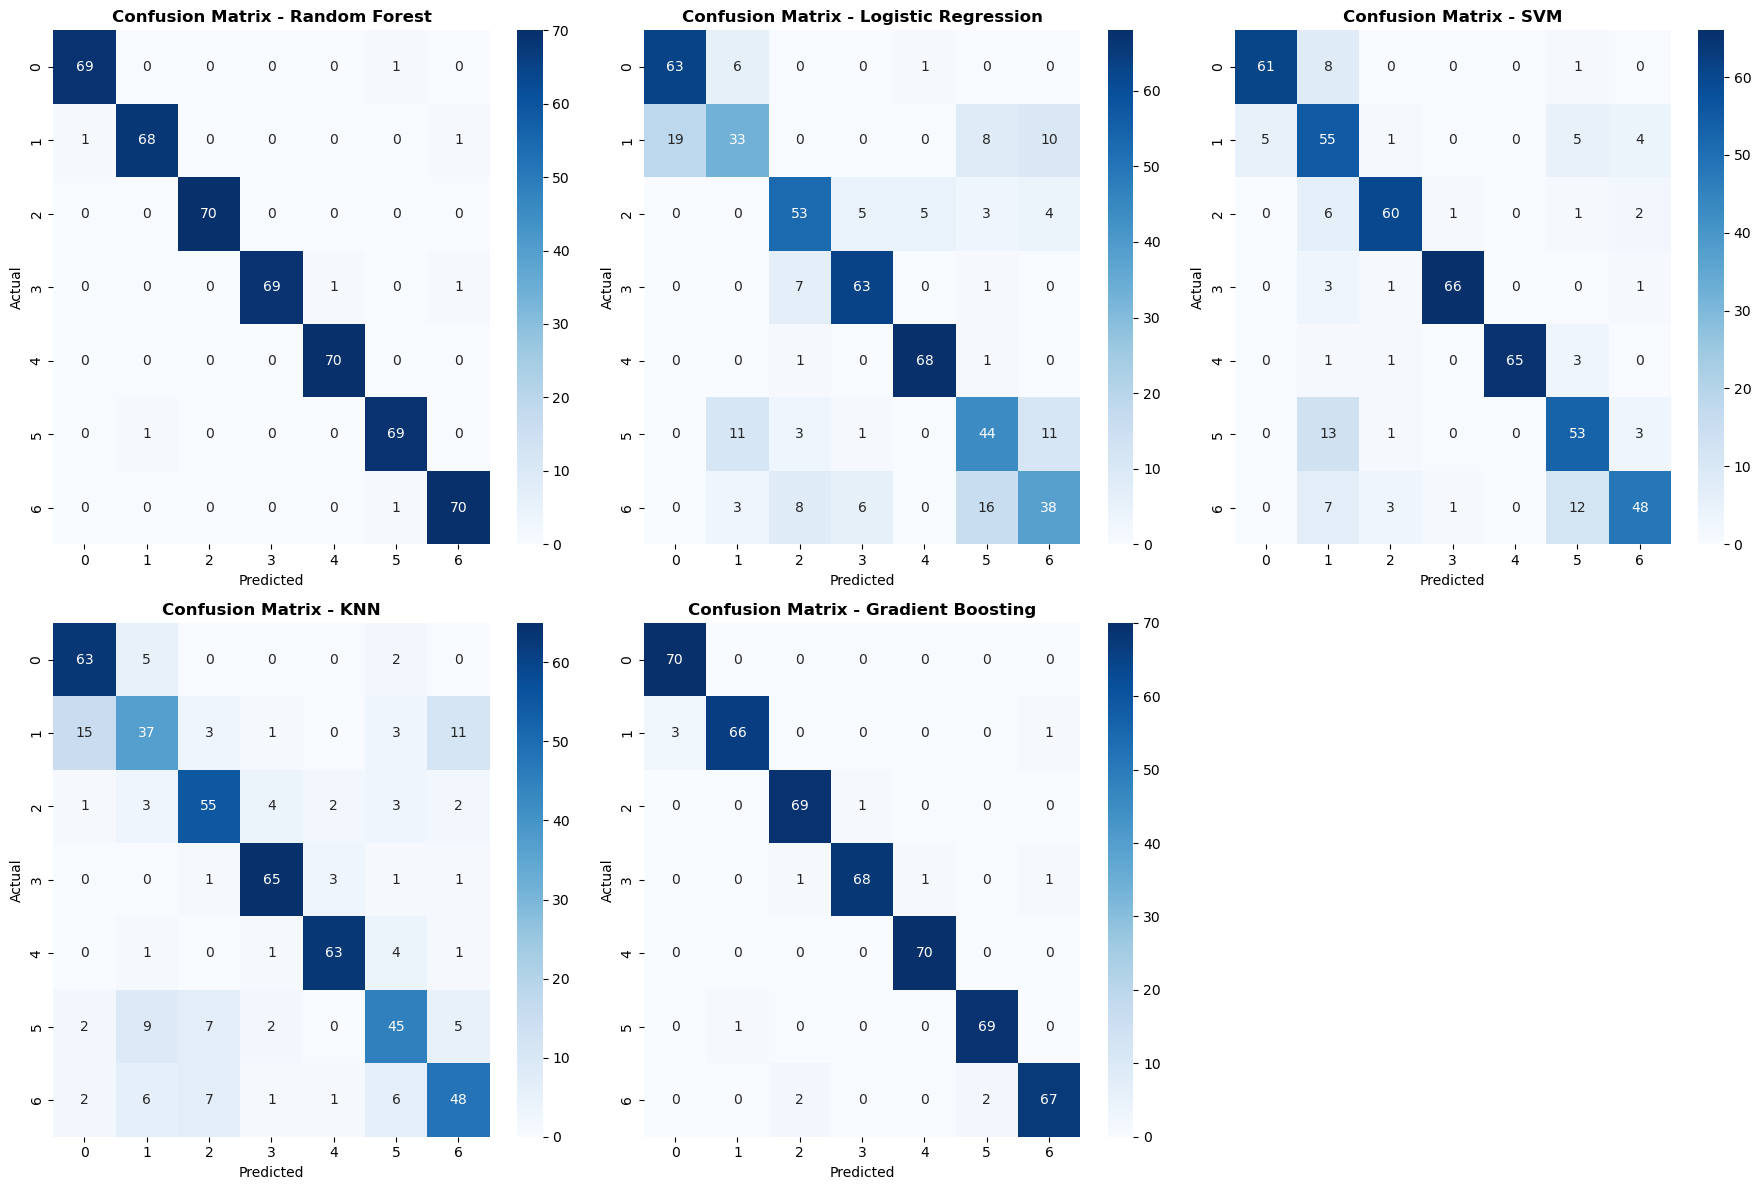

In [23]:
# 3.1 Initialize Models
print("\n3.1 Initialize Models")
print("-" * 22)

models = {
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

print(f"✓ {len(models)} models initialized")

# 3.2 Train Models dan Cross Validation
print("\n3.2 Model Training dan Cross Validation")
print("-" * 40)

cv_scores = {}
trained_models = {}

# Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Cross validation
    cv_score = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
    cv_scores[name] = cv_score
    
    # Train on full training set
    model.fit(X_train, y_train)
    trained_models[name] = model
    
    print(f"  CV Accuracy: {cv_score.mean():.4f} (+/- {cv_score.std() * 2:.4f})")

# 3.3 Model Evaluation
print("\n3.3 Model Evaluation")
print("-" * 22)

results = {}

for name, model in trained_models.items():
    # Predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'CV_Mean': cv_scores[name].mean(),
        'CV_Std': cv_scores[name].std()
    }
    
    print(f"\n{name} Results:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")

# 3.4 Confusion Matrix Visualization
print("\n3.4 Confusion Matrix Visualization")
print("-" * 35)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, (name, model) in enumerate(trained_models.items()):
    if i < len(axes):
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'Confusion Matrix - {name}', fontweight='bold')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

# Remove empty subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig('gambar/07_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()


3.5 Model Comparison Visualization
-----------------------------------

Model Performance Summary:
                     Accuracy  Precision  Recall  F1-Score  CV_Mean  CV_Std
Random Forest          0.9858     0.9859  0.9858    0.9858   0.9776  0.0078
Logistic Regression    0.7358     0.7274  0.7358    0.7288   0.7394  0.0314
SVM                    0.8293     0.8454  0.8293    0.8337   0.8458  0.0186
KNN                    0.7642     0.7601  0.7642    0.7606   0.7695  0.0097
Gradient Boosting      0.9736     0.9738  0.9736    0.9735   0.9634  0.0131


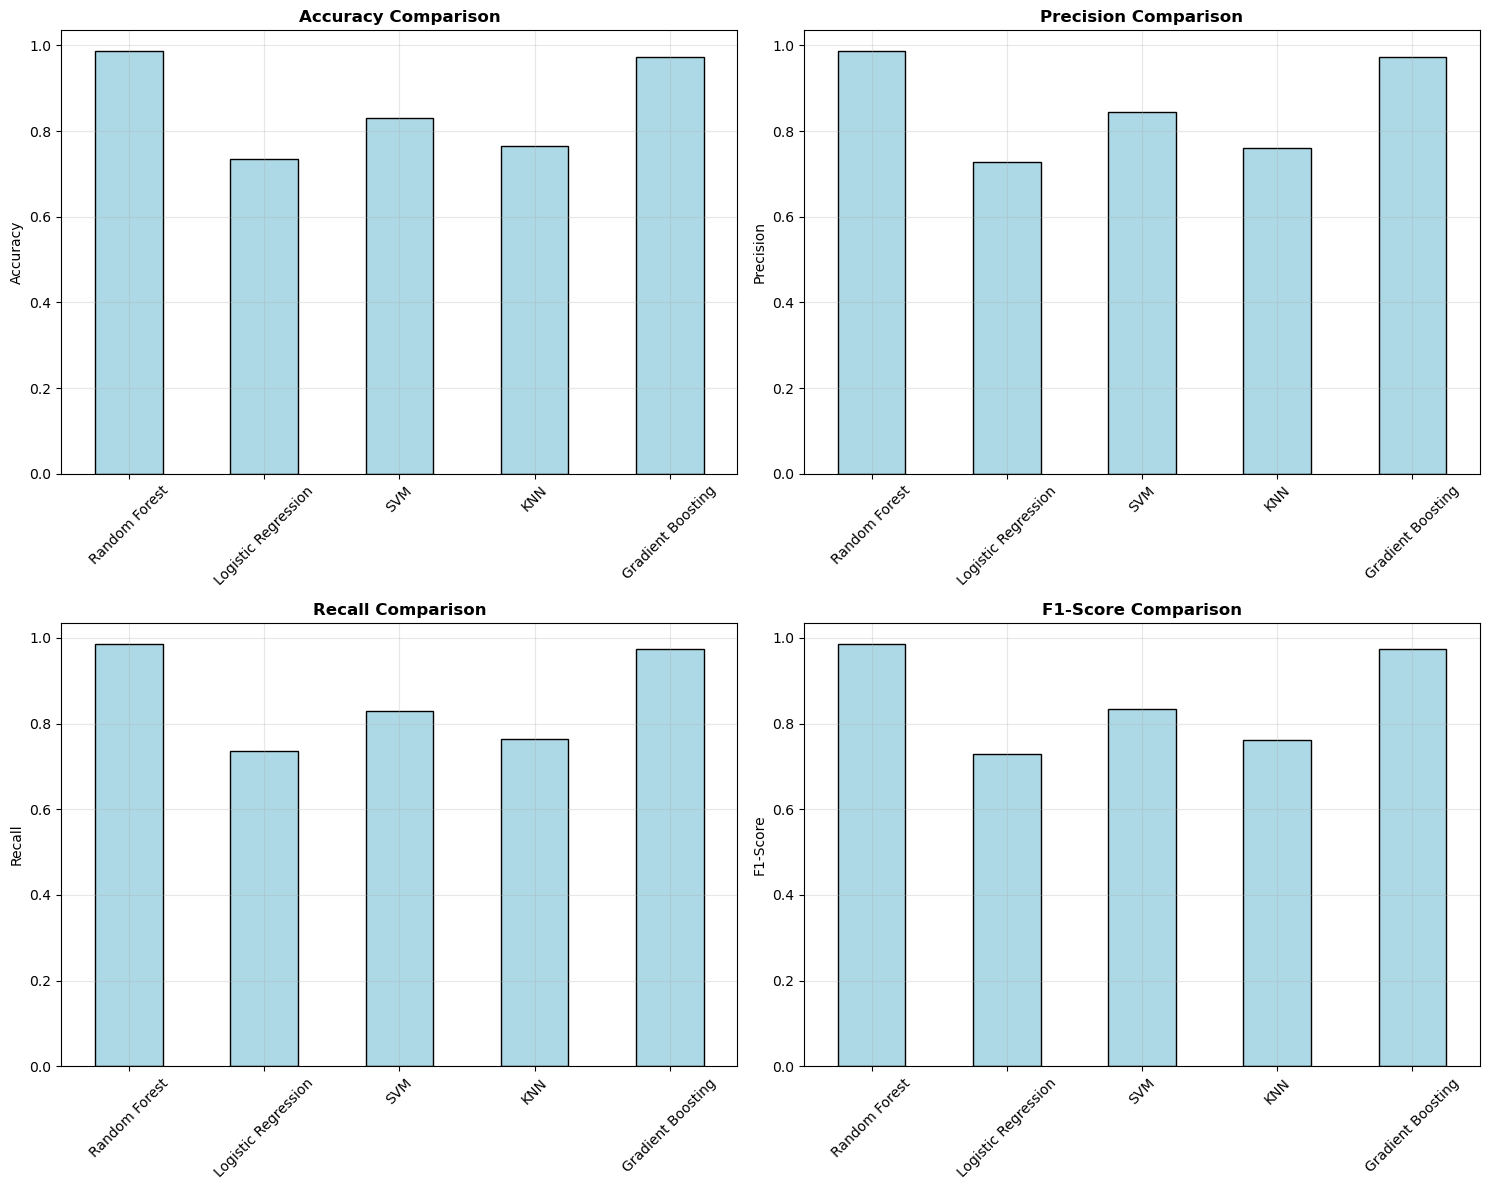


3.6 Best Model Selection
-------------------------
✓ Best Model: Random Forest
✓ Best F1-Score: 0.9858

TAHAP 4: HYPERPARAMETER TUNING

Memastikan data dan hasil modeling tersedia...
✓ Semua variabel tersedia


In [24]:
# 3.5 Model Comparison Visualization
print("\n3.5 Model Comparison Visualization")
print("-" * 35)

# Create results DataFrame
results_df = pd.DataFrame(results).T
print("\nModel Performance Summary:")
print(results_df.round(4))

# Bar plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    results_df[metric].plot(kind='bar', ax=ax, color='lightblue', edgecolor='black')
    ax.set_title(f'{metric} Comparison', fontweight='bold')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gambar/08_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 3.6 Best Model Selection
print("\n3.6 Best Model Selection")
print("-" * 25)

best_model_name = results_df['F1-Score'].idxmax()
best_model = trained_models[best_model_name]
best_score = results_df.loc[best_model_name, 'F1-Score']

print(f"✓ Best Model: {best_model_name}")
print(f"✓ Best F1-Score: {best_score:.4f}")

print("\n" + "="*50)
print("TAHAP 4: HYPERPARAMETER TUNING")
print("="*50)

# Pastikan semua variabel yang dibutuhkan tersedia
print("\nMemastikan data dan hasil modeling tersedia...")
required_vars = ['X_train', 'X_test', 'y_train', 'y_test', 'results_df', 'trained_models']
missing_vars = []

for var in required_vars:
    if var not in locals():
        missing_vars.append(var)

if missing_vars:
    print(f"✗ Error: Variabel berikut tidak tersedia: {missing_vars}")
    print("Mohon jalankan semua tahap sebelumnya terlebih dahulu")
    exit()
else:
    print("✓ Semua variabel tersedia")

# TAHAP 4: HYPERPARAMETER TUNING

In [25]:
# 4.1 Select Top 3 Models for Tuning
print("\n4.1 Select Top Models for Tuning")
print("-" * 35)

# Sort models by F1-Score and select top 3
top_models = results_df.sort_values('F1-Score', ascending=False).head(3)
print("Top 3 models selected for hyperparameter tuning:")
print(top_models[['Accuracy', 'F1-Score']].round(4))

# 4.2 Define Parameter Grids
print("\n4.2 Define Parameter Grids")
print("-" * 30)

param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
        'kernel': ['rbf', 'linear']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0]
    }
}


4.1 Select Top Models for Tuning
-----------------------------------
Top 3 models selected for hyperparameter tuning:
                   Accuracy  F1-Score
Random Forest        0.9858    0.9858
Gradient Boosting    0.9736    0.9735
SVM                  0.8293    0.8337

4.2 Define Parameter Grids
------------------------------



4.3 Hyperparameter Optimization
-----------------------------------

Tuning Random Forest...
  Best CV Score: 0.9741
  Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20}

Tuning Gradient Boosting...
  Best CV Score: 0.9584
  Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2}

Tuning SVM...
  Best CV Score: 0.9130
  Best Parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

4.4 Evaluate Tuned Models
----------------------------

Random Forest (Tuned) Results:
  Accuracy: 0.9858
  Precision: 0.9859
  Recall: 0.9858
  F1-Score: 0.9858

Gradient Boosting (Tuned) Results:
  Accuracy: 0.9797
  Precision: 0.9797
  Recall: 0.9797
  F1-Score: 0.9796

SVM (Tuned) Results:
  Accuracy: 0.9289
  Precision: 0.9295
  Recall: 0.9289
  F1-Score: 0.9290

4.5 Before vs After Tuning Comparison
----------------------------------------

F1-Score Comparison (Before vs After Tuning):
               Model  Before

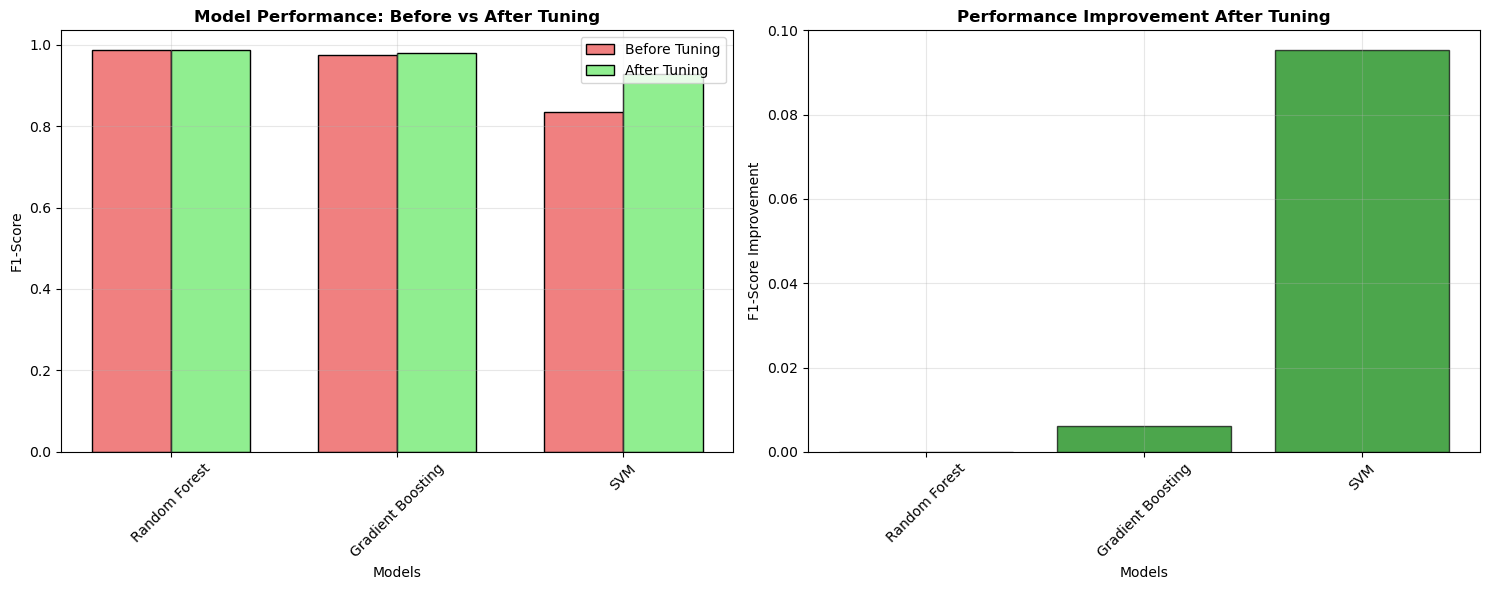

In [26]:
# 4.3 Hyperparameter Optimization
print("\n4.3 Hyperparameter Optimization")
print("-" * 35)

tuned_models = {}
tuning_results = {}

for model_name in top_models.index:
    print(f"\nTuning {model_name}...")
    
    base_model = models[model_name]
    param_grid = param_grids[model_name]
    
    # Use RandomizedSearchCV untuk parameter grid yang besar
    if model_name in ['Random Forest', 'Gradient Boosting']:
        search = RandomizedSearchCV(
            base_model, param_grid, n_iter=50, cv=3, 
            scoring='f1_weighted', random_state=42, n_jobs=-1
        )
    else:
        search = GridSearchCV(
            base_model, param_grid, cv=3, 
            scoring='f1_weighted', n_jobs=-1
        )
    
    # Fit the search
    search.fit(X_train, y_train)
    
    # Store results
    tuned_models[model_name] = search.best_estimator_
    tuning_results[model_name] = {
        'best_params': search.best_params_,
        'best_cv_score': search.best_score_,
        'original_score': results[model_name]['F1-Score']
    }
    
    print(f"  Best CV Score: {search.best_score_:.4f}")
    print(f"  Best Parameters: {search.best_params_}")

# 4.4 Evaluate Tuned Models
print("\n4.4 Evaluate Tuned Models")
print("-" * 28)

tuned_results = {}

for name, model in tuned_models.items():
    # Predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    tuned_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }
    
    print(f"\n{name} (Tuned) Results:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")

# 4.5 Before vs After Tuning Comparison
print("\n4.5 Before vs After Tuning Comparison")
print("-" * 40)

comparison_data = []
for model_name in tuned_models.keys():
    comparison_data.append({
        'Model': model_name,
        'Before_F1': results[model_name]['F1-Score'],
        'After_F1': tuned_results[model_name]['F1-Score'],
        'Improvement': tuned_results[model_name]['F1-Score'] - results[model_name]['F1-Score']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nF1-Score Comparison (Before vs After Tuning):")
print(comparison_df.round(4))

# Visualization of improvement
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Before vs After comparison
x = range(len(comparison_df))
width = 0.35

ax1.bar([i - width/2 for i in x], comparison_df['Before_F1'], width, 
        label='Before Tuning', color='lightcoral', edgecolor='black')
ax1.bar([i + width/2 for i in x], comparison_df['After_F1'], width, 
        label='After Tuning', color='lightgreen', edgecolor='black')

ax1.set_xlabel('Models')
ax1.set_ylabel('F1-Score')
ax1.set_title('Model Performance: Before vs After Tuning', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_df['Model'], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Improvement bar chart
colors = ['green' if imp > 0 else 'red' for imp in comparison_df['Improvement']]
ax2.bar(comparison_df['Model'], comparison_df['Improvement'], color=colors, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Models')
ax2.set_ylabel('F1-Score Improvement')
ax2.set_title('Performance Improvement After Tuning', fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('gambar/09_tuning_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
# Improvement bar chart
colors = ['green' if imp > 0 else 'red' for imp in comparison_df['Improvement']]
ax2.bar(comparison_df['Model'], comparison_df['Improvement'], color=colors, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Models')
ax2.set_ylabel('F1-Score Improvement')
ax2.set_title('Performance Improvement After Tuning', fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('gambar/09_tuning_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>


4.6 Final Model Selection
-------------------------
✓ Final Best Model: Random Forest
✓ Final Best F1-Score: 0.9858
✓ Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20}
✓ Final model saved

4.7 Final Model Confusion Matrix
--------------------------------


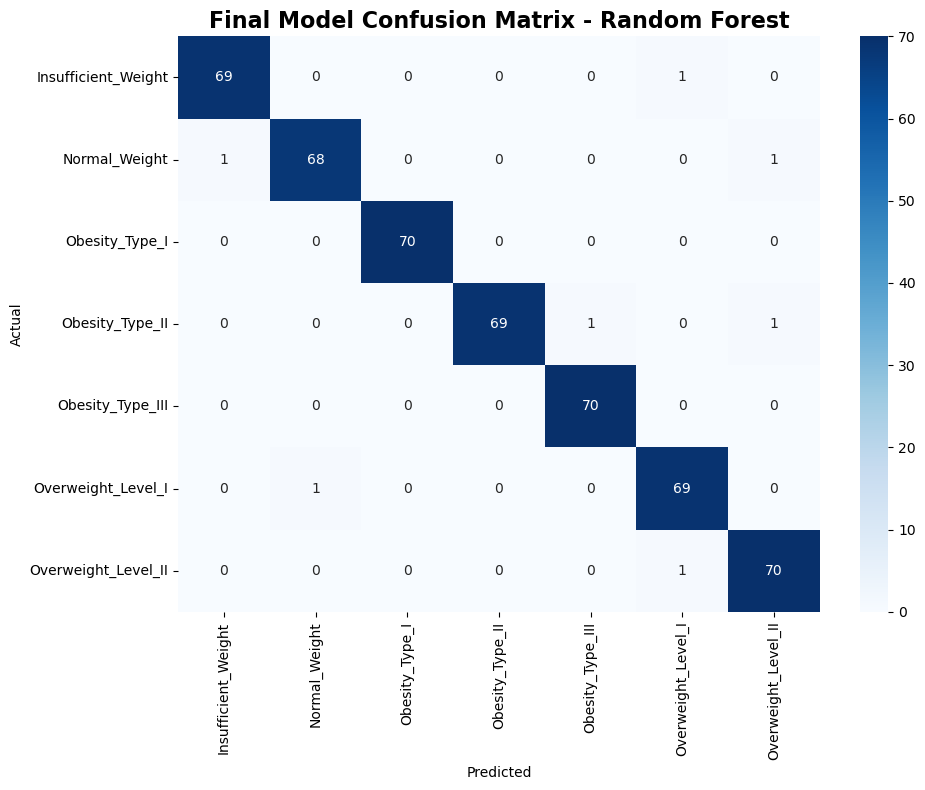

In [28]:
# 4.6 Final Model Selection
print("\n4.6 Final Model Selection")
print("-" * 25)

# Select best tuned model
tuned_results_df = pd.DataFrame(tuned_results).T
final_best_model_name = tuned_results_df['F1-Score'].idxmax()
final_best_model = tuned_models[final_best_model_name]
final_best_score = tuned_results_df.loc[final_best_model_name, 'F1-Score']

print(f"✓ Final Best Model: {final_best_model_name}")
print(f"✓ Final Best F1-Score: {final_best_score:.4f}")
print(f"✓ Best Parameters: {tuning_results[final_best_model_name]['best_params']}")

# Save final model
if not os.path.exists('models'):
    os.makedirs('models')

joblib.dump(final_best_model, 'models/best_model.pkl')
print("✓ Final model saved")

# 4.7 Final Confusion Matrix
print("\n4.7 Final Model Confusion Matrix")
print("-" * 32)

y_pred_final = final_best_model.predict(X_test)
cm_final = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.title(f'Final Model Confusion Matrix - {final_best_model_name}', fontsize=16, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('gambar/10_final_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
# 4.8 Classification Report
print("\n4.8 Final Classification Report")
print("-" * 32)
print(classification_report(y_test, y_pred_final, target_names=le_target.classes_))

print("\n" + "="*80)
print("ANALISIS SELESAI!")
print("="*80)

# Pastikan semua variabel akhir tersedia
try:
    print(f"✓ Dataset processed: {df.shape[0]} samples, {len(feature_columns)} features")
    print(f"✓ Best model: {final_best_model_name}")
    print(f"✓ Final F1-Score: {final_best_score:.4f}")
    print(f"✓ Models saved in 'models/' directory")
    print(f"✓ Visualizations saved in 'gambar/' directory")
    print("✓ Features used:", feature_columns[:5], "..." if len(feature_columns) > 5 else "")
    print(f"✓ Total features: {len(feature_columns)}")
except NameError as e:
    print(f"✗ Warning: Beberapa variabel tidak tersedia: {e}")
    print("✓ Analisis sebagian berhasil dilakukan")


4.8 Final Classification Report
--------------------------------
                     precision    recall  f1-score   support

Insufficient_Weight       0.99      0.99      0.99        70
      Normal_Weight       0.99      0.97      0.98        70
     Obesity_Type_I       1.00      1.00      1.00        70
    Obesity_Type_II       1.00      0.97      0.99        71
   Obesity_Type_III       0.99      1.00      0.99        70
 Overweight_Level_I       0.97      0.99      0.98        70
Overweight_Level_II       0.97      0.99      0.98        71

           accuracy                           0.99       492
          macro avg       0.99      0.99      0.99       492
       weighted avg       0.99      0.99      0.99       492


ANALISIS SELESAI!
✓ Dataset processed: 2111 samples, 17 features
✓ Best model: Random Forest
✓ Final F1-Score: 0.9858
✓ Models saved in 'models/' directory
✓ Visualizations saved in 'gambar/' directory
✓ Features used: ['TUE', 'BMI', 'CAEC_encoded', 'MTRANS_e